# LSTM Model

df -> integer encoded songs per playlist

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import implicit
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

from collections import defaultdict
from importlib import reload

import pickle

from joblib import delayed, Parallel

import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import square, mean, log, dot, flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import df_utils
import mf_utils
import rnn_utils

In [3]:
df = pd.read_csv("cleaned_data_0.2.csv", index_col=[0])
songs_df = pd.read_csv("songs_DF.csv", index_col=[0])

train_df = pd.read_csv("Train_DF.csv", index_col=[0])

# split_train_df = pd.read_csv("Split_Train_DF.csv", index_col=[0])
excl = pickle.load(open("Excluded_Songs_Series.p", "rb"))

# CANNOT use songs_df here as order is different
indx_to_song = mf_utils.indx_mapping(df.spotify_id.unique())

# CHANGE FROM EARLIER NOTEBOOKS - now using train_df and not split_train_df
indx_to_playlist = mf_utils.indx_mapping(train_df.playlist_id.unique())

song_to_indx = mf_utils.indx_mapping(df.spotify_id.unique(), indx_to_item=False)
playlist_to_indx = mf_utils.indx_mapping(train_df.playlist_id.unique(), indx_to_item=False)

/Users/vedantvarshney/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_ratings_matrix = mf_utils.df_to_sparse(train_df, all_songs=df.spotify_id.unique())

# Number of latent factors now 300
wrmf_model = implicit.als.AlternatingLeastSquares(factors=300)

# items_users matrix in this case is the songs_playlist matrix
wrmf_model.fit(train_ratings_matrix)

In [5]:
wrmf_model.user_factors.shape

(10531, 300)

In [6]:
wrmf_model.item_factors.shape

(105152, 300)

In [7]:
playlist_to_indx[6736120]

0

In [22]:
train_df

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,vagalume,sitevagalume,Eraser,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7oolFzHipTMg2nL7shhdz2,÷ (Deluxe),64.0,0.640,0.812,-5.647,0.0834,0.086000,0.000000,0.0509,0.914,86.013
1,vagalume,sitevagalume,Castle On The Hill,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PCUP3dWmTjcTtXY02oFdT,÷ (Deluxe),78.0,0.461,0.834,-4.868,0.0989,0.023200,0.000011,0.1400,0.471,135.007
2,vagalume,sitevagalume,Dive,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,51ChrwmUPDJvedPQnIU8Ls,÷ (Deluxe),75.0,0.761,0.386,-6.158,0.0399,0.355000,0.000000,0.0953,0.526,134.943
3,vagalume,sitevagalume,Shape Of You,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7qiZfU4dY1lWllzX7mPBI3,÷ (Deluxe),85.0,0.825,0.652,-3.183,0.0802,0.581000,0.000000,0.0931,0.931,95.977
4,vagalume,sitevagalume,Perfect,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,0tgVpDi06FyKpA1z0VMD4v,÷ (Deluxe),86.0,0.599,0.448,-6.312,0.0232,0.163000,0.000000,0.1060,0.168,95.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560575,8tracks,11027,Instant Karma,John Lennon,10532,"indie rock,unknown, alternative & punk",scascio,2E9wKgL8NN7Tvydqcjoh7v,Gimme Some Truth,53.0,0.624,0.931,-9.988,0.1160,0.000899,0.001490,0.0631,0.140,119.887
560576,8tracks,11027,This Must Be the Place (Naive Melody),Talking Heads,10532,"indie rock,unknown, alternative & punk",scascio,6aBUnkXuCEQQHAlTokv9or,Speaking in Tongues (Deluxe Version),71.0,0.942,0.641,-10.150,0.0333,0.331000,0.179000,0.0280,0.966,114.443
560577,8tracks,11027,Rock & Roll (Full-Length Version),The Velvet Underground,10532,"indie rock,unknown, alternative & punk",scascio,1o6DclZHw0HomxXEQR1ijX,Loaded: Re-Loaded 45th Anniversary Edition,62.0,0.494,0.735,-8.347,0.0345,0.004010,0.000003,0.5440,0.742,132.526
560578,8tracks,11027,So. Central Rain (I'm Sorry),R.E.M.,10532,"indie rock,unknown, alternative & punk",scascio,3AdyPM9rfgfPxoWS4tKh2O,Live At The Olympia,38.0,0.339,0.950,-4.797,0.0556,0.000804,0.000034,0.9700,0.460,142.148


In [5]:
reload(rnn_utils)

<module 'rnn_utils' from '../rnn_utils.py'>

In [6]:
print("Number of unique songs: ", len(df.spotify_id.unique()))

Number of unique songs:  105152


In [7]:
vocab_size = int(40e3)

song_vocab = pd.value_counts(df.spotify_id)[:vocab_size].index.values

In [8]:
song_vocab

array(['4rHZZAmHpZrA3iH5zx8frV', '4v0hWD4N6qefyFrmSGLjTV',
       '2dOTkLZFbpNXrhc24CnTFd', ..., '6WwcLGKHE8vI3lNEdlkFGG',
       '40M41a88QX30oAGAGzDXVv', '3cRyadOju8uciYpcLPA58n'], dtype=object)

In [9]:
song_to_indx_vocab = {v:k for (k,v) in pd.Series(song_vocab).iteritems()}

In [13]:
song_to_indx_vocab

{'4rHZZAmHpZrA3iH5zx8frV': 0,
 '4v0hWD4N6qefyFrmSGLjTV': 1,
 '2dOTkLZFbpNXrhc24CnTFd': 2,
 '2Yer0p7uB2lVBUAtANuuQp': 3,
 '7aE5WXu5sFeNRh3Z05wwu4': 4,
 '62yJjFtgkhUrXktIoSjgP2': 5,
 '7ef4DlsgrMEH11cDZd32M6': 6,
 '32FmHP0AUjZcYMb1EmAaho': 7,
 '60jzFy6Nn4M0iD1d94oteF': 8,
 '3gVkvfZ4rCmZ7oxjAWk1n9': 9,
 '4RXpgGM7A4Hg7cFBoH5KyF': 10,
 '47Slg6LuqLaX0VodpSCvPt': 11,
 '6F5c58TMEs1byxUstkzVeM': 12,
 '38zwkK6TtTjIW9tpYBfZ3D': 13,
 '0nJW01T7XtvILxQgC5J7Wh': 14,
 '2dLLR6qlu5UJ5gk0dKz0h3': 15,
 '79z9QkhHePTFsSeVw9uyj0': 16,
 '6O20JhBJPePEkBdrB5sqRx': 17,
 '4zOfy9kqJlG0ZXvcaSh4gv': 18,
 '4TVuirwgzxe9fWRBoWtPpq': 19,
 '60nZcImufyMA1MKQY3dcCH': 20,
 '6z5Yh7kOKeLjqIsNdokIpU': 21,
 '0OLEbgcc7U3frxMuYvWOfo': 22,
 '1WINLcGPEw9jDs2z0zLKIU': 23,
 '0BBZuOGGBj9u4X3rAfmae8': 24,
 '05SBRd4fXgn8FX7bf8BCAE': 25,
 '7Jh1bpe76CNTCgdgAdBw4Z': 26,
 '7MnT7msJZg3XBAS0OTfGrB': 27,
 '4nVBt6MZDDP6tRVdQTgxJg': 28,
 '0SuG9kyzGRpDqrCWtgD6Lq': 29,
 '6CcJMwBtXByIz4zQLzFkKc': 30,
 '6U0FIYXCQ3TGrk4tFpLrEA': 31,
 '4aebBr4JAihzJQR0

In [11]:
train_playlist_songs_matrix, lengths_series = rnn_utils.create_playlist_song_matrix(train_df, song_to_indx_vocab,
                                                                                    song_vocab=song_vocab)

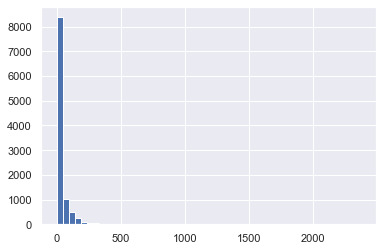

In [14]:
lengths_series.hist(bins=50)

Let us check that train_playlist_songs_matrix has the shape (num_playlists, None, num_latent_factors):

In [15]:
print(train_playlist_songs_matrix[2])

[ 1650  2470 12702 10126   618 11509  4244 21269 23955  8798   610]


In [200]:
reload(rnn_utils)

<module 'rnn_utils' from '../rnn_utils.py'>

In [201]:
def generate_xy_sample():
    while True:
        for playlist in train_playlist_songs_matrix:
            xsample, ysample = rnn_utils.prepare_sample(playlist, wrmf_model.item_factors, len(song_vocab))
            yield xsample, ysample

In [202]:
a, b = next(generate_xy_sample())

In [203]:
for x in next(generate_xy_sample()):
    print(x.shape)
    print(x.dtype, "\n")

(6, 300)
float32 

(6, 40000)
int32 



In [204]:
assert (b == 1).any()

In [205]:
num_latent_factors = 300

In [206]:
train_dataset = tf.data.Dataset.from_generator(generate_xy_sample,
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=(tf.TensorShape([None, num_latent_factors]), tf.TensorShape([None, len(song_vocab)]))
                                              )

In [207]:
next(train_dataset.batch(1).as_numpy_iterator())[0].shape

(1, 6, 300)

In [208]:
next(train_dataset.batch(1).as_numpy_iterator())[1].shape

(1, 6, 40000)

In [209]:
vocab_series = pd.Series(df.spotify_id.unique())
vocab_indxs = vocab_series[vocab_series.isin(song_vocab)].index.values

In [210]:
vocab_indxs

array([     0,      1,      2, ..., 102729, 103205, 103323])

In [215]:
item_factors_T = tf.convert_to_tensor(wrmf_model.item_factors[vocab_indxs].T, dtype=tf.float32)
item_factors_T

<tf.Tensor: shape=(300, 40000), dtype=float32, numpy=
array([[ 7.28567038e-03,  1.66929681e-02,  3.65867056e-02, ...,
         2.52660393e-04,  8.53341888e-04,  8.68330171e-05],
       [ 1.24141085e-03,  8.21403321e-03, -6.20000437e-02, ...,
         5.90004784e-05,  1.63462886e-04,  2.30912938e-05],
       [ 6.19946420e-03,  3.29057798e-02,  3.05970013e-02, ...,
         7.32240878e-05,  2.87839503e-04,  4.26557490e-05],
       ...,
       [ 1.31261081e-03,  7.77553301e-03,  3.58183263e-03, ...,
         1.46105653e-04,  3.11143231e-04,  1.75349924e-04],
       [ 8.38077348e-03,  8.44603870e-03,  3.17770452e-03, ...,
         1.55322225e-04, -8.75585683e-05,  5.37384767e-05],
       [-8.83147214e-03, -9.73241869e-04, -1.91729981e-02, ...,
         1.22181664e-04, -3.98004806e-04,  1.04874634e-04]], dtype=float32)>

In [236]:
BATCH_SIZE = 10

item_factors_T_batch = tf.tile(tf.expand_dims(item_factors_T, axis=0), multiples=[BATCH_SIZE, 1, 1])

In [237]:
item_factors_T_batch.shape

TensorShape([10, 300, 40000])

In [238]:
item_factors_T_batch.dtype

tf.float32

In [254]:
def custom_loss(y_true, y_pred):
    
#  y_true - shape (batch_size, playlist_length, multihot ie vocab_size ie 40k)
#  y_pred - shape (batch_size, playlist_length, 300)

    loss = 0

#     Cast to a boolean mask
    y_true = tf.cast(y_true, tf.bool)
#     print("y_true shape, ", y_true.shape)

# Adjust global variable if batch size is different than the one anticipated.
# Slightly ugly solution (changing global variables) but significantly reduces unnecessary computation.

#     if item_factors_T_batch.shape[0] != y_true.shape[0]:
    item_factors_T_batch = tf.tile(tf.expand_dims(item_factors_T, axis=0), multiples=[y_true.shape[0], 1, 1])
    
#     Contains all the necessary dot products
    composite = tf.matmul(y_pred, item_factors_T_batch)
    
#     print("composite shape ", composite.shape)
        
# TODO - improve such that only have to run through mask once.
    correct = tf.boolean_mask(composite, y_true)
    incorrect = tf.boolean_mask(composite, ~y_true)
    
    loss -= tf.math.reduce_sum(log(tf.math.sigmoid(correct))).numpy()
    loss -= tf.math.reduce_sum(log(1-tf.math.sigmoid(incorrect))).numpy()
    
    return loss
        

In [220]:
a, b = next(generate_xy_sample())

In [221]:
a = tf.convert_to_tensor(a[np.newaxis, :])

b = tf.convert_to_tensor(b[np.newaxis, :])

In [251]:
print(a.shape)
print(a.dtype)

(1, 6, 300)
<dtype: 'float32'>


In [252]:
print(b.shape)
print(b.dtype)

(1, 6, 40000)
<dtype: 'int32'>


In [255]:
custom_loss(b, a)

167430.25270462036